# Projet 7 - Indexation automatiques d'images

## Introduction

Nous allons dans ce projet essayer de proposer un algorithme de classsification d'images. Les images sont des images de chiens et notre but sera d'essayer de proposer un algorithme capable de catégoriser les races de chiens. Nous allons utiliser pour cela le dataset founi par l'université de standford


## Les données 

Nos données sont des images de chiens répertoriées dans des dossiers. Il y a 119 races de chiens (119 dossiers donc) et chaque dossier contient un certain nombre d'images.

Notre but dans un premier temps va être de répertorier les races de chiens en utilisant des méthodes de traitement d'images associés à des méthodes de classification supervisées pour pouvoir apprendre et prédire la race d'un chien sur une image.

Nous allons donc traiter les images. Pour cela nous allons d'abord montrer les modifications qui ont été opérés sur toutes les images en prenant une image en exemple.

Nous allons tout d'abord simplement prendre l'image en noir et blanc:

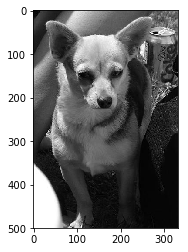

In [5]:
%matplotlib inline
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

file = r'C:\Users\zakis\Documents\OpenClassroom\Projet 7\Images\n02085620-Chihuahua\n02085620_10074.jpg'
im_gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im_gray, cmap = 'gray')

Nous allons égaliser l'histogrammes pour afficher un maximum de contraste.

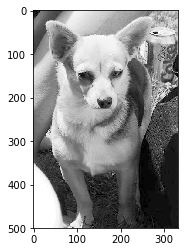

In [11]:
equ = cv2.equalizeHist(im_gray)
plt.imshow(equ, cmap = 'gray')

Nous allons utiliser un léger filtre gaussien pour pouvoir supprimer les quelques imperfections des images

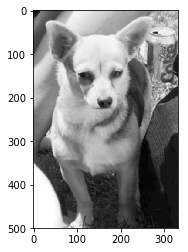

In [13]:
blur = cv2.blur(equ,(3,3))
plt.imshow(blur, cmap = 'gray')

Nous allons redimensionner les images toutes à la même dimension: 128x128

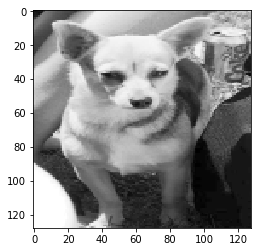

In [15]:
rsz = cv2.resize(blur, (128, 128)) 
plt.imshow(rsz, cmap = 'gray')

Nous allons procéder de la même manière pour toutes les images.

Nous allons ensuite passer à la détection de features grâce à l'algorithme SIFT. Cette algorithme détecte les coins sans distinctions d'échelle et d'orientations:

In [16]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 100)
kp, des = sift.detectAndCompute(rsz,None)

Nous choisissons un nombre de features importants car nous voulons pouvoir repérer un maximum de features sans pour autant trop complexifié nos calculs utltérieurs

In [3]:
directory = r'C:\Users\zakis\Documents\OpenClassroom\Projet 7\Images'
nb_img = [0]
for i in range(0, 10):
    x = []
    print(str(i))
    folder = directory + '\\' + os.listdir(directory)[i]
    for j in range(0, len(os.listdir(folder))):
        file = os.listdir(folder)[j]
        img = folder + '\\' + file
        im_gray = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        equ = cv2.equalizeHist(im_gray)
        blur = cv2.blur(equ,(3,3))
        rsz = cv2.resize(blur, (128, 128)) 
        sift = cv2.xfeatures2d.SIFT_create(nfeatures = 100)
        kp, des = sift.detectAndCompute(rsz,None)
        race = i* np.ones((len(des),1))
        nb_img = (max(nb_img) + 1) * np.ones((len(des),1))
        y = np.concatenate([race, nb_img, des], axis = 1)
        if len(x) == 0:
            x = y
        else:
            x = np.concatenate([x, y])
        
    df = pd.DataFrame(x)
    df.to_csv(str(i)+'_races_prepro.csv')

0
1
2
3
4
5
6
7
8
9


Ce script nous permet de créer un dataset pour chque race de chien, ce qui va nous permettre de pouvoir étudier nos résultats sur un plus petit nombre de races et voir comment ceux-ci évoluent.

Nous récupérons pour le moment deux races et essayons de voir si on peut avoir des bons résultats avec un résultat binaire.

Ce que nous allons tout d'abord faire c'est essayer de séparer ces features en classes de manières non supervisés. Ce pourquoi nous allons utiliser l'algorithme des k-means.

In [1]:

import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('races_prepo.csv')
df = df.drop('Unnamed: 0', 1)
df = df.drop('Unnamed: 0.1', 1)

race = df.iloc[:,0].values
nb_image = df.iloc[:,1].values
sift_features = df.iloc[:,2:].values

sc = StandardScaler()
data_normalized = sc.fit_transform(sift_features)

pca = decomposition.PCA(n_components=0.8)
X_PCA = pca.fit_transform(data_normalized)


C:\Users\zakis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:

# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wcss = []
score = []
for i in range(5, 160, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_PCA)
    wcss.append(kmeans.inertia_)

NameError: name 'plt' is not defined

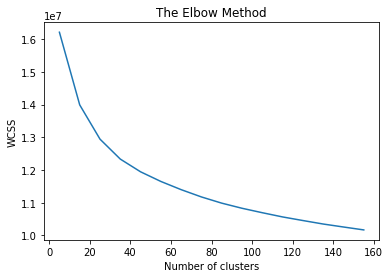

In [6]:
plt.plot(range(5, 160, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

La méthode du coude nous indique ici qu'il faut choisir un K=50 approximativement et c'est ce que nous allons choisir.

Nous avons donc classé toutes les features de chaque image en 50 classes. Celles-ci vont nous aider à créer une représentation bag of features. Nous allons utiliser cette représenatation pour entrainer une rrégression logistique qui va nous prédire la classe de chacune des images.

In [8]:
# KMeans avec 50 classes
nb_class = 50
kmeans = KMeans(n_clusters = nb_class, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X_PCA)

# Création de la représentation bag of features
x = []
for i in np.unique(nb_image):
    arg_where = np.argwhere(nb_image == i)
    y_kmeans_image = y_kmeans[arg_where]
    y = [sum(y_kmeans_image == classe)[0] for classe in np.unique(y_kmeans)]
    r = sum(race[arg_where])/len(race[arg_where])
    y = np.concatenate([np.array(y).reshape(1,nb_class), r * np.ones((1,1))], axis = 1)
    if len(x) == 0:
        x = y
    else :
        x = np.concatenate([x, y])

X = x[:, :nb_class]
Y = x[:, nb_class]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Régression logistiques
classifier = LogisticRegression(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Accuracy score
print(accuracy_score(y_test, y_pred))


0.19270833333333334


On voit un score qui est assez faible mais pas nul (on rappelle qu'il y a dix classes donc que la baseline est à 10%). 20% est un score plutôt faible au vu du faite que notre problème possède en faite 120 races de chiens.

## Conclusion

On a essayé avec des méthodes traditionnelles de traitement d'images et de machine learning de produire un algorithme qui apprend les races de chiens en fonction des images. Nous avons traiter nos images en noir et blanc, en leurs appliquant un léger filtre gaussien, en égalisant leurs histogrammes, et en les mettant sous une taille définie (128,128).

Nous avons ensuite cherché à classifier les features données par l'algorithme sift pour créer une représentation en bag of features qui nous permet de faire apprendre une régression logistique sur cette représetation. Nous obtenons un résultat faible de 20%. 

Nous allons donc nous tourner dans une seconde partie vers des méthodes dites de deep learning avec le réseau vgg16.